In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from copy import deepcopy as dp
import seaborn as sns

import warnings

In [2]:
from backtest import *

In [3]:
path_to_data = 'data'
tickers = ['AMD', 'INTC']
start_date = '2015-01-01'
end_date = '2020-01-01'

selected_cols = ['EPS (Basic)']

In [4]:
data_dict = warmup(tickers, path_to_data, start_date, end_date, selected_cols)

In [5]:
class Strategy():
    '''
    Простая стратегия, которая равномерно покупает компании из всего получаемого списка 
    '''

    def portfolio_init(self, start_money, regular_money, money_freq, decision_freq):
        
        if money_freq < 1:
            print('money_freq should be >= 1!')
            raise
        if decision_freq < 1:
            print('decision_freq should be >= 1!')
            raise
        
        self.regular_money = regular_money
        self.regular_money_freq = money_freq  # количество дней для регулярных поступлений 
        self.portfolio = {'cash': start_money}  # текущее состояние портфеля
        self.days_left = self.regular_money_freq
        self.decision_freq = decision_freq
        self.days_to_decision = self.decision_freq


    def init_ticker(self, ticker):
        self.portfolio[ticker] = {'price': 0, 'volume': 0}
    
    def portfolio_update(self, ticker, new_price, new_amount, add):
        add = True if add == 'to_buy' else False
        if ticker not in self.portfolio:
            self.init_ticker(ticker)
        if ticker == 'cash':
            self.portfolio[ticker] += new_amount
        elif add:  # добавляем объем в портфель, перевзвешиваем цену
            cash_spend = new_price * new_amount
            self.portfolio[ticker]['price'] = ((self.portfolio[ticker]['price'] * self.portfolio[ticker]['volume'] + cash_spend) / \
                                               (self.portfolio[ticker]['volume'] + new_amount))
            self.portfolio[ticker]['volume'] += new_amount
            self.portfolio['cash'] -= cash_spend
            if self.portfolio['cash'] < 0:
                print('Negative cash!')
                print(self.portfolio['cash'])
                print(ticker, cash_spend)
                raise
        else:  # продаем, ср. цена та же
            cash_earned = new_price * new_amount
            self.portfolio[ticker]['volume'] -= new_amount
            self.portfolio['cash'] += cash_earned


    def init_decision(self):
        des = {'to_buy': {},
               'to_sell': {}}
        return des 


    def get_decision(self, index, time, state):
        '''
        Сама стратегия. Её можно изменять как угодно
        ''' 
        # FIXME: мб проблема множественного вызова внутри дня

        current_decision = self.init_decision()
        added_money = 0
        self.days_left -= 1  
        self.days_to_decision -= 1
        
        if self.days_left == 0:
            added_money = self.regular_money  # for portfolio value calc
            self.portfolio['cash'] += added_money
            self.days_left = self.regular_money_freq

        # покупаем компании, если возможно
        # докупаю в день денег
        if self.days_to_decision == 0:
            current_money = self.portfolio['cash']
            company_share = current_money / len(state)
            for company, company_state in state.items():  # пробегаем по всем компаниям и записываем решение
                current_decision['to_buy'][company] = company_share  # сколько денег на одну компанию
            self.days_to_decision = self.decision_freq
            
        return current_decision, added_money
 

In [6]:
def calc_portfolio_value(portfolio, state, new_cash):
    value = -new_cash  # subtract new cash added
    for ticker, info in portfolio.items():
        if ticker == 'cash':
            continue
        ticker_price = state[ticker]['adj_close']
        ticker_portfolio_amount = info['volume']
        value += ticker_price * ticker_portfolio_amount
    return value

In [47]:
def plot_results(df):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(df['portfolio_values'], label='portfolio values')
    plt.ylabel('USD')
    plt.grid()
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(df['returns'], label='returns')
    plt.ylabel('%')
    plt.grid()
    plt.legend()
    
    plt.subplot(3, 1, 3)
    sns.histplot(df['returns'], kde=False, bins=60, label='returns distribution',
                 line_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.ylabel('%')
    plt.grid()
    plt.legend()
    
    plt.show()

In [48]:
def run_backtest(path_to_data, tickers, strategy, strategy_params, 
                 start_date, end_date, commission, selected_cols,
                 viz=True, logging=True):
    
    data = warmup(tickers, path_to_data, start_date, end_date, selected_cols, logging)
    
    strategy.portfolio_init(**strategy_params)
    
    portfolio_values = []
    times = []
    
    for index, (time, state) in enumerate(data.items()):
        des, new_money = strategy.get_decision(index, time, state)  # основываясь на текущем портфеле и новой информации, стратегия принимает решение
        cash_left = 0
        for side, tickers in des.items():
            for ticker, money in tickers.items():
                price = state[ticker]['adj_close']
                amount = money // price  # FIXME: check if it's correct for sell
                cashback = money % price
                strategy.portfolio_update(ticker, price, amount, side)
                cash_left += cashback
                if logging:
                    print('Added:', index, time, ticker, price, amount, side)
        strategy.portfolio_update('cash', 1, cash_left, True)
        curr_value = calc_portfolio_value(strategy.portfolio, state, new_money)
        portfolio_values.append(curr_value)
        times.append(time)
        
    res_data = np.array([portfolio_values, times]).T
    res_df = pd.DataFrame(res_data, columns=['portfolio_values', 'times'])
    res_df['portfolio_values'] = res_df['portfolio_values'].astype(float)
    res_df['times'] = pd.to_datetime(res_df['times'])
    res_df = res_df.set_index('times')
    res_df['returns'] = res_df['portfolio_values'].pct_change().replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(value=0)
    
    if viz:
        plot_results(res_df)
        
    return res_df, strategy

In [49]:
path_to_data = 'data'
tickers = ['AMD', 'INTC']
start_date = '2015-01-01'
end_date = '2020-01-01'

selected_cols = ['EPS (Basic)']

commission = 0.001

In [50]:
strategy_params = {}
strategy_params['start_money'] = 10000
strategy_params['regular_money'] = 1000
strategy_params['money_freq'] = 30
strategy_params['decision_freq'] = 30

In [51]:
strategy = Strategy()

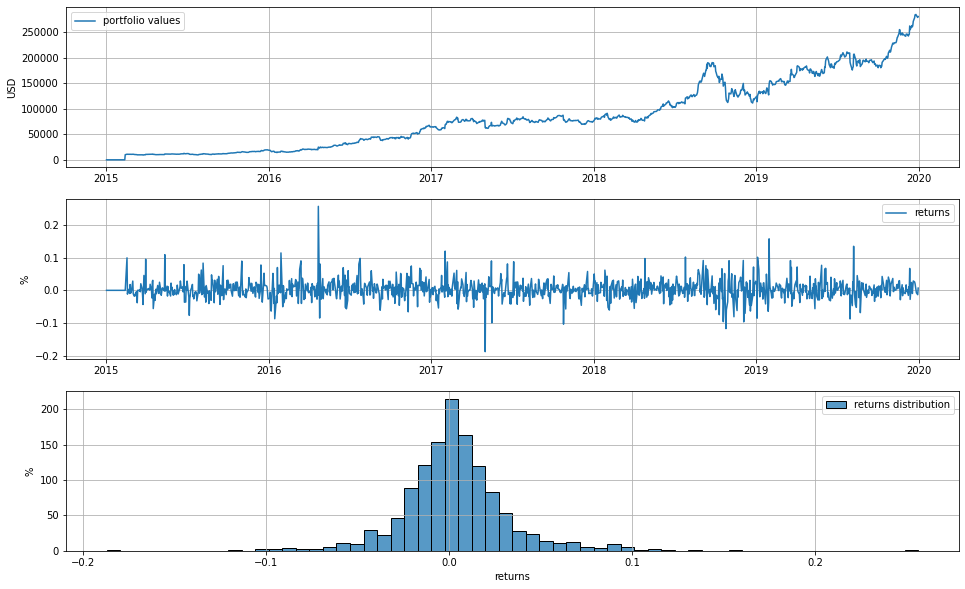

In [52]:
res, done_strategy = run_backtest(path_to_data, tickers, strategy, strategy_params, 
                   start_date, end_date, commission, selected_cols, logging=False)

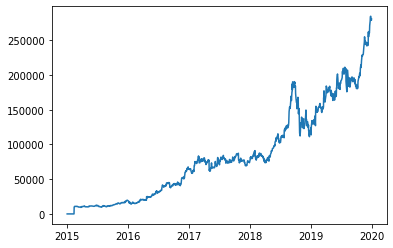

In [145]:
plt.plot(res['times'], res['portfolio_values'])

In [139]:
res['portfolio_values']

0                        0
1                        0
2                        0
3                        0
4                        0
               ...        
1253     283890.1941604614
1254     284656.7115211487
1255     282526.7985153198
1256    278782.79848098755
1257     280706.3882293701
Name: portfolio_values, Length: 1258, dtype: object

In [62]:
res.portfolio

{'cash': 135.1682586669922,
 'AMD': {'price': 5.1070440142023905, 'volume': 5159.0},
 'INTC': {'price': 33.8599562770442, 'volume': 760.0}}

In [17]:
strategy.portfolio

{'cash': 24.409801483154297,
 'AMD': {'price': 2.6700000762939453, 'volume': 2059.0},
 'INTC': {'price': 30.671871185302734, 'volume': 166.79509925842285}}

In [18]:
old_portfolio

{'cash': 10000}